# Correlation of RAI to Eth price moves - Data as of 4-5-2021

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univariate autoregression models allowing for multivariate time series analysis.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$

For our VAR model, we will have a vector of prices, $P$ of EthRai(marketPriceEth), RaiUSD(marketPriceUsd), EthUSD price moves, error between redemption price and rai market price, redemption price, total collateral, Uniswap RAI balance relative to total supply, max debt ceiling, and collaterlization ratio.

#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differencing can be used to make the data stationary.
* Data is on the same scale
* Time sampling is consistent 

### Other methods with fewer assumptions

Non-parametric Bayesian VAR models have been under development and appear to perform well and can operate on nonlinear relationship, heteroscedasticity, and non Gaussian error data[1,2].

Another popular time series analysis modeling technique is the Autorgressive Integrated Moving Average (ARIMA) model. These models are often used in forecasting or when the data shoes evidence of non-stationarity. For multiple time series vectors, like we have here, extensions of the ARIMA model are available, such ARIMAX model that has exogenous variable inputs. ARIMAX models do not have an assumption of Gaussian errors as it uses a maximum likelihood estimation function to fit.

#### References
- 1 Kalli, Maria & Griffin, Jim E., 2018. "Bayesian nonparametric vector autoregressive models," Journal of Econometrics, Elsevier, vol. 203(2), pages 267-282.
- 2 Jeliazkov, Ivan. (2013). Nonparametric Vector Autoregressions: Specification, Estimation, and Inference. Advances in Econometrics. 33. 10.1108/S0731-9053(2013)0000031009. 


We have taken the trade off in assumption for this first version correlation model vs a non-parametric approach for simplicity sake, that current robust python VAR implementations exist, and for illustrative purposes around the concepts we are addressing.


In [1]:
# import libraries
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt


## Data

We import the data obtained in the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and preprocess it.

In [2]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [3]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,currentFsmUpdate,...,debtAvailableToSettle,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH)
0,11857308,1988.440433,1988.577499,1613338681,3.14,1.0,0.002589,4.670500,0,{'value': '1803.65643044'},...,0.0,115792089237316195423570985008687.9,0.068533,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,661.764843
1,11860793,2788.440433,2788.617717,1613384616,3.14,1.0,0.002481,4.377049,0,{'value': '1803.65643044'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
2,11861040,2788.440433,2788.657935,1613387890,3.14,1.0,0.002481,4.406833,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
3,11861337,2788.440433,2788.657935,1613392101,3.14,1.0,0.002481,4.419266,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
4,11861474,3048.440433,3048.645955,1613394096,3.14,1.0,0.001769,3.194330,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.116162,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,801.933727


### Exploratory Analysis

In [4]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,totalCollateral,Eth_price,debtAvailableToSettle,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH)
count,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03,...,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03
mean,1.203147e+07,3.473195e+07,3.511759e+07,1.615655e+09,3.054531,0.999970,0.001798,3.155879,0.021002,4.688509e+07,...,158638.032194,1774.171191,230686.787731,128119.119200,848.921648,0.850664,0.999970,0.999763,3.054530,3.050972e+07
std,9.978664e+04,1.211140e+07,1.219603e+07,1.327480e+06,0.043963,0.000055,0.000288,0.381351,0.191691,1.454494e+07,...,55421.848305,179.311718,343038.776521,66575.787675,244.744430,0.325361,0.000055,0.000441,0.043962,1.134689e+07
min,1.185731e+07,1.988440e+03,1.988577e+03,1.613339e+09,3.013686,0.999796,0.001452,2.850455,0.000000,1.000000e+07,...,14.892360,1328.192602,0.000000,-8000.336813,3.000000,0.168066,0.999796,0.998373,3.013686,6.019337e+02
25%,1.194500e+07,3.309371e+07,3.373953e+07,1.614504e+09,3.020102,0.999942,0.001645,2.995186,0.000000,4.443395e+07,...,155013.370985,1648.210000,12393.446281,137006.918480,792.000000,0.600722,0.999942,0.999535,3.020102,2.843231e+07
50%,1.202997e+07,3.592230e+07,3.632733e+07,1.615636e+09,3.031552,0.999992,0.001728,3.069590,0.000000,5.727986e+07,...,175794.054025,1786.194279,30243.907560,153039.995184,974.000000,0.931377,0.999992,0.999935,3.031552,3.174299e+07
75%,1.211847e+07,4.275394e+07,4.302486e+07,1.616812e+09,3.095314,1.000009,0.001937,3.215063,0.000000,5.727986e+07,...,192567.134023,1894.250000,284207.004680,176936.045621,999.000000,1.086065,1.000009,1.000075,3.095314,3.782203e+07
max,1.220577e+07,4.899876e+07,4.918825e+07,1.617973e+09,3.140000,1.000051,0.004474,8.055382,3.000000,5.727986e+07,...,209393.009759,2132.768622,943944.359793,190652.573941,1021.000000,1.562592,1.000051,1.000408,3.140000,4.526917e+07


In [5]:
graphData.columns

Index(['blockNumber', 'erc20CoinTotalSupply', 'globalDebt', 'timestamp',
       'hourlyredemptionPriceActual', 'hourlyredemptionRateActual',
       'hourlymarketPriceEth', 'hourlymarketPriceUsd', 'activeLiquidations',
       'currentFsmUpdate', 'currentMedianizerUpdate', 'debtCeiling',
       'liquidationsStarted', 'totalAnnualizedStabilityFee', 'totalCollateral',
       'Eth_price', 'coinAddress', 'coinUniswapPair',
       'currentCoinMedianizerUpdate', 'debtAvailableToSettle',
       'globalDebtCeiling', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice', 'RAIInUniswapV2(RAI/ETH)'],
      dtype='object')

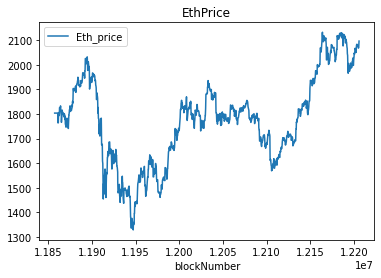

In [6]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

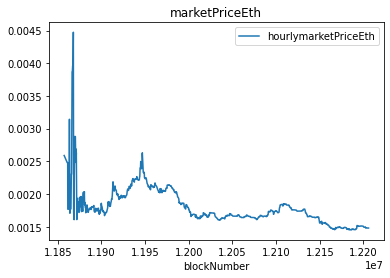

In [7]:
graphData.plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceEth')

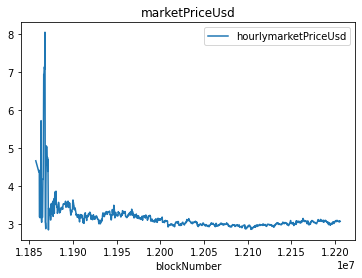

In [8]:
graphData.plot(x='blockNumber',y='hourlymarketPriceUsd',kind='line',title='marketPriceUsd')

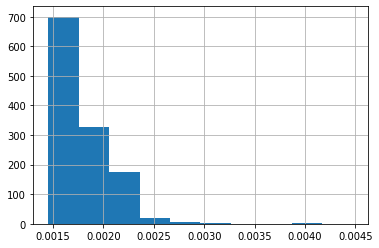

In [9]:
graphData.hourlymarketPriceEth.hist()

Due to the large spikes the market prices during the system initialization, we will cut out the first 100 observations.

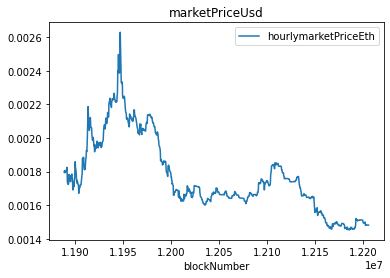

In [10]:
graphData[100:].plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceUsd')

## New features Creation
Based on discussions with the Rai team, we will add the following signls to the VAR model:
* ### New variables to add (with calculations - references from Graph Data):
    * Error = hourlyredemptionPriceActual - hourlymarketPriceUsd
    * Redemption rate = hourlyredemptionPriceActual
    * Uniswap RAI balance relative to total RAI supply = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])/globalDebt
    * Rai supply/Rai cap (max debt ceiling) =  globalDebt/debtCeiling
    * ETH locked in collateral = totalCollateral
    * Collateralization ratio = (totalCollateral * hourlymarketPriceEth)/(globalDebt * hourlymarketPriceEth)
    
### 15 min lagged Eth

Based on a conversation in the Rai and Block Science shared Slack, a 15 min lagged Eth price signal was requested. We have created it below, but have left it out of the analysis because as we are using an autoregressive model, which an autoregressor with a order >= 1 includes the last periods value (an order of 2 includes the last two periods, and so on), and the fact that our data is approximately every hour, this signal is redundant for our final model. 

In [11]:
# since difference is nan on first value, seed list with initial market price
laggedEthValue = [graphData['hourlymarketPriceEth'][0]]
graphData['timestampDiff'] = graphData.timestamp.diff()
#15 mins
seconds = 60 * 15
lastRowDiff = 0


for i, row in graphData.iterrows():
    if i > 0:
        lastRowIndex = i-1
        if row['timestampDiff'] >= seconds:
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        else:
            lastRowIndex = i-2
            print("Using last Eth value because diff wasn't block occured before 15 mins had passed")
            print(lastRowIndex)
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        lastRowDiff = row['timestampDiff']
    else:
        pass
    
graphData['15MinLaggedmarketPriceEth'] = laggedEthValue

Using last Eth value because diff wasn't block occured before 15 mins had passed
371
Using last Eth value because diff wasn't block occured before 15 mins had passed
565
Using last Eth value because diff wasn't block occured before 15 mins had passed
600
Using last Eth value because diff wasn't block occured before 15 mins had passed
631
Using last Eth value because diff wasn't block occured before 15 mins had passed
792
Using last Eth value because diff wasn't block occured before 15 mins had passed
871
Using last Eth value because diff wasn't block occured before 15 mins had passed
907
Using last Eth value because diff wasn't block occured before 15 mins had passed
931
Using last Eth value because diff wasn't block occured before 15 mins had passed
1020
Using last Eth value because diff wasn't block occured before 15 mins had passed
1120
Using last Eth value because diff wasn't block occured before 15 mins had passed
1124
Using last Eth value because diff wasn't block occured before 

In [12]:
# create features
graphData['error'] = graphData['hourlyredemptionPriceActual'] - graphData['hourlymarketPriceUsd']
graphData['UniswapRAIBalanceRelativeToTotalSupply'] =  graphData['RAIInUniswapV2(RAI/ETH)'] / graphData['globalDebt']
graphData['MaxDebtCeiling'] = graphData['globalDebt'] / graphData['debtCeiling']
graphData['CollateralizationRatio'] =  (graphData['totalCollateral'] * graphData['hourlymarketPriceEth']) / (graphData['globalDebt'] * graphData['hourlymarketPriceEth'])

In [13]:
# subset data to vector for VAR
P = graphData[100:][['error','hourlyredemptionPriceActual','hourlyredemptionRateActual',
                     'hourlymarketPriceEth','hourlymarketPriceUsd',
                     'Eth_price','totalCollateral','UniswapRAIBalanceRelativeToTotalSupply',
                     'MaxDebtCeiling','CollateralizationRatio']]

In [14]:
P.describe()

,error,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
count,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000
mean,-0.048535,3.047074,0.999969,0.001772,3.095608,1768.334230,171400.016326,0.864300,0.759889,0.004515
std,0.111980,0.037597,0.000057,0.000224,0.139789,184.998919,36122.679359,0.051903,0.069409,0.000343
min,-0.510456,3.013686,0.999796,0.001452,2.864213,1328.192602,41235.497030,0.677439,0.583213,0.003637
25%,-0.107828,3.018898,0.999940,0.001641,2.990572,1627.249309,158968.796309,0.842338,0.719961,0.004292
50%,-0.027082,3.030796,0.999986,0.001712,3.057706,1781.848390,179311.518352,0.868044,0.760836,0.004432
75%,0.034289,3.064580,1.000011,0.001902,3.181662,1884.886224,193679.015807,0.907927,0.815602,0.004694
max,0.160603,3.135706,1.000051,0.002631,3.639484,2132.768622,209393.009759,0.944594,1.000348,0.005530


## Time Analysis

When examining the data, we developed the following two questions:
1. Are we sampling more often then the control period or is the controller not activated everytime it could be because the error is not large enough?
2. What type of samplimg time do we have? 


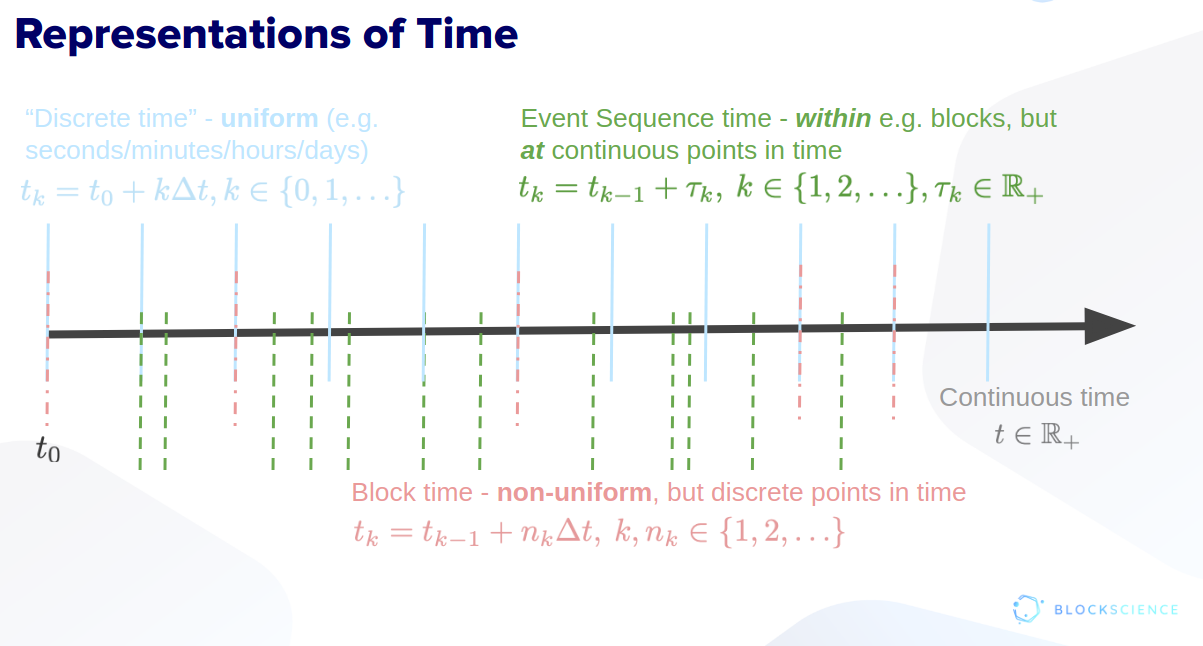

To answer these questions, we will calculate the timestamp difference and create a histogram of the time differences and determine if we have equal time sampling or not.

In [15]:
# convert timestamps to human readable
graphData['timestamp_human'] = pd.to_datetime(graphData['timestamp'],origin='unix',unit='s')

In [16]:
graphData['timestampDiff'] = graphData.timestamp.diff()

In [17]:
graphData.timestampDiff.describe()

count     1237.000000
mean      3746.471302
std       1689.978372
min        333.000000
25%       3075.000000
50%       3728.000000
75%       4211.000000
max      45935.000000
Name: timestampDiff, dtype: float64

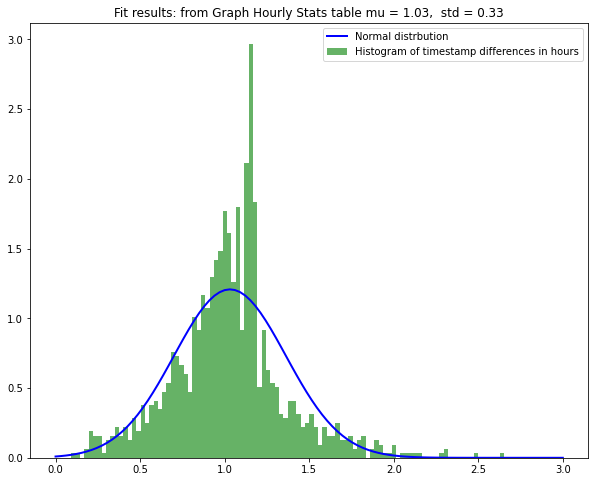

In [18]:
# convert to hours
data = graphData.timestampDiff[2:].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

**Conclusion**: Based on the histogram above, we can see that the timestamp differences are approximately normally distributed around every hour. Time series analysis of uneven sample periods is rather limited in the literature, with three dominant methods emerging: "Hope and Pray", interpolation, and state based models, which are complex to configure and beyond the scope of this analysis. Because our results are more centered around zero than a normal distribution, we will continue with our VAR model as is. If the spread of timestamp differences were greater, we would explore interpolation methods.

### Data Transformations

We will take the log of the data to reduce the skewness and take the first difference to make the data stationary, meaning that the distribution does not change when shifted by tie.

In [19]:
# Difference and log values
for i in P.columns:
    P[i +'_log_differenced'] = np.log(P[i]).diff()
    P[i +'_log_differenced'].iat[0] = np.log(P[i].iat[0])
    

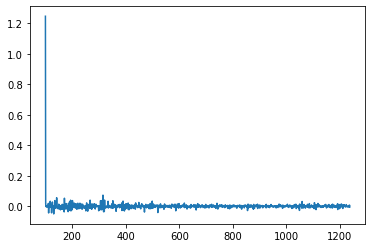

In [20]:
P.hourlymarketPriceUsd_log_differenced.plot()

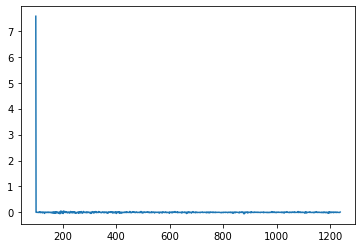

In [21]:
P.Eth_price_log_differenced.plot()

In [22]:
P.describe()

,error,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio,error_log_differenced,hourlyredemptionPriceActual_log_differenced,hourlyredemptionRateActual_log_differenced,hourlymarketPriceEth_log_differenced,hourlymarketPriceUsd_log_differenced,Eth_price_log_differenced,totalCollateral_log_differenced,UniswapRAIBalanceRelativeToTotalSupply_log_differenced,MaxDebtCeiling_log_differenced,CollateralizationRatio_log_differenced
count,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,428.000000,1138.000000,1.138000e+03,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1.138000e+03
mean,-0.048535,3.047074,0.999969,0.001772,3.095608,1768.334230,171400.016326,0.864300,0.759889,0.004515,0.013227,0.000973,-1.907410e-08,-0.005725,0.000987,0.006721,0.010449,-0.000052,-0.000230,-4.795095e-03
std,0.111980,0.037597,0.000057,0.000224,0.139789,184.998919,36122.679359,0.051903,0.069409,0.000343,0.671042,0.033879,8.432900e-06,0.187575,0.038325,0.224433,0.315249,0.011276,0.019584,1.660428e-01
min,-0.510456,3.013686,0.999796,0.001452,2.864213,1328.192602,41235.497030,0.677439,0.583213,0.003637,-3.152742,-0.000402,-1.037547e-04,-6.321753,-0.050115,-0.059595,-0.103865,-0.205875,-0.259214,-5.594052e+00
25%,-0.107828,3.018898,0.999940,0.001641,2.990572,1627.249309,158968.796309,0.842338,0.719961,0.004292,-0.199622,-0.000051,0.000000e+00,-0.002107,-0.004017,-0.002497,-0.000308,-0.000626,-0.000328,-6.066972e-04
50%,-0.027082,3.030796,0.999986,0.001712,3.057706,1781.848390,179311.518352,0.868044,0.760836,0.004432,0.000000,0.000000,0.000000e+00,-0.000042,0.000000,0.000000,0.000016,0.000022,0.000023,-2.444082e-07
75%,0.034289,3.064580,1.000011,0.001902,3.181662,1884.886224,193679.015807,0.907927,0.815602,0.004694,0.186722,0.000008,0.000000e+00,0.000725,0.003946,0.003836,0.001006,0.001038,0.001351,4.661199e-04
max,0.160603,3.135706,1.000051,0.002631,3.639484,2132.768622,209393.009759,0.944594,1.000348,0.005530,5.265167,1.142854,9.142756e-05,0.081117,1.245416,7.563245,10.627055,0.093861,0.246604,1.096707e-01


In [23]:
P = P[['error_log_differenced','hourlyredemptionPriceActual_log_differenced',
       'hourlyredemptionRateActual_log_differenced',
       'hourlymarketPriceEth_log_differenced','hourlymarketPriceUsd_log_differenced', 
       'Eth_price_log_differenced',
       'totalCollateral_log_differenced',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced',
       'MaxDebtCeiling_log_differenced',
       'CollateralizationRatio_log_differenced']]


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [24]:
# scaler objects
scalers = {}
for i in P.columns:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers[i] = scaler
    string = i + '_standardized'
    P[string] = scaler.transform(values)
    

Mean: 0.013227, StandardDeviation: 0.670258
Mean: 0.000973, StandardDeviation: 0.033864
Mean: -0.000000, StandardDeviation: 0.000008
Mean: -0.005725, StandardDeviation: 0.187493
Mean: 0.000987, StandardDeviation: 0.038308
Mean: 0.006721, StandardDeviation: 0.224335
Mean: 0.010449, StandardDeviation: 0.315110
Mean: -0.000052, StandardDeviation: 0.011271
Mean: -0.000230, StandardDeviation: 0.019576
Mean: -0.004795, StandardDeviation: 0.165970


The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [25]:
P = P[['error_log_differenced_standardized','hourlyredemptionPriceActual_log_differenced_standardized',
       'hourlyredemptionRateActual_log_differenced_standardized',
       'hourlymarketPriceEth_log_differenced_standardized','hourlymarketPriceUsd_log_differenced_standardized', 
       'Eth_price_log_differenced_standardized',
       'totalCollateral_log_differenced_standardized',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized',
       'MaxDebtCeiling_log_differenced_standardized',
       'CollateralizationRatio_log_differenced_standardized']]


In [26]:
P.describe()

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
count,4.280000e+02,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03,1.138000e+03
mean,-7.757619e-18,-6.505061e-17,1.686919e-16,1.562166e-17,1.473143e-17,1.958225e-16,1.960939e-17,1.115452e-17,2.775862e-18,2.789277e-17
std,1.001170e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00
min,-4.723508e+00,-4.063038e-02,-1.230670e+01,-3.368679e+01,-1.333991e+00,-2.956117e-01,-3.627733e-01,-1.826178e+01,-1.322993e+01,-3.367635e+01
25%,-3.175616e-01,-3.025793e-02,2.262862e-03,1.929457e-02,-1.306173e-01,-4.108954e-02,-3.413511e-02,-5.100571e-02,-5.016623e-03,2.523590e-02
50%,-1.973352e-02,-2.874709e-02,2.262862e-03,3.030850e-02,-2.576952e-02,-2.995845e-02,-3.310839e-02,6.530862e-03,1.291991e-02,2.888990e-02
75%,2.588490e-01,-2.850293e-02,2.262862e-03,3.440426e-02,7.722516e-02,-1.286105e-02,-2.996555e-02,9.666478e-02,8.078842e-02,3.169983e-02
max,7.835700e+00,3.371936e+01,1.084880e+01,4.631777e-01,3.248490e+01,3.368414e+01,3.369174e+01,8.332438e+00,1.260925e+01,6.896782e-01


In [27]:
P.dropna(inplace=True)

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [28]:
for i in P.columns:
    print(i)
    result = adfuller(P[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

error_log_differenced_standardized
ADF Statistic: -6.428202
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlyredemptionPriceActual_log_differenced_standardized
ADF Statistic: -4.840712
p-value: 0.000045
reject, no unit root present
----------------------------------
hourlyredemptionRateActual_log_differenced_standardized
ADF Statistic: -7.019921
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlymarketPriceEth_log_differenced_standardized
ADF Statistic: -8.197578
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlymarketPriceUsd_log_differenced_standardized
ADF Statistic: -12.326990
p-value: 0.000000
reject, no unit root present
----------------------------------
Eth_price_log_differenced_standardized
ADF Statistic: -13.311709
p-value: 0.000000
reject, no unit root present
----------------------------------
totalCollateral_log_differenced_standardized
ADF Statistic: -3.935938

Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Fit model

To help determine ideal number of lags for our model, we will perform a heuristic SVD to determine the ideal number of lags. We will fit our model with an autocorrelation between 1 and 15 to determine what combination has the lower Akaike information criterion(AIC), which is used to evaluates how well a model fits to the data. We don't want to have too high of an autocorrelation to prevent overfitting. The AIC penalizes the model for the more variables that are present so that the best-fit model according to AIC, is the one that explains the greatest amount of variation using the fewest possible independent variables.


# Run with each loss. Plot on same axis, if the scale works. Why we should use 1

In [29]:
aic = []
for i in range(1,16):
    model = VAR(P)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
bic = []
for i in range(1,16):
    model = VAR(P)
    results = model.fit(i,ic='bic')
    bic.append(results.bic)

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/hom

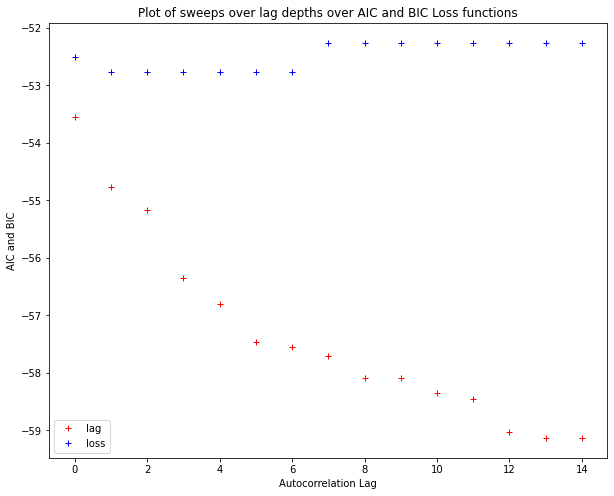

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.plot(bic, 'b+')
plt.legend(['lag','loss'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC and BIC')
plt.title('Plot of sweeps over lag depths over AIC and BIC Loss functions')
plt.show()

## What are the implications of this? Gives support for PI controller
## without at least two Var, there is no relationship. You need to have more lags to have predictive power

Based on our analysis, a lower autocorrelation lag appears to be better. We will select a value of 1 to fit our model.

In [31]:
# instantiate the var model object from statsmodels
model = VAR(P)

# fit model with determined lag values
results = model.fit(2)

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [32]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Apr, 2021
Time:                     11:43:47
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -52.7712
Nobs:                     426.000    HQIC:                  -53.9803
Log likelihood:           5831.30    FPE:                1.63721e-24
AIC:                     -54.7698    Det(Omega_mle):     1.01187e-24
--------------------------------------------------------------------
Results for equation error_log_differenced_standardized
                                                                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------------------------------
const                                                                         -

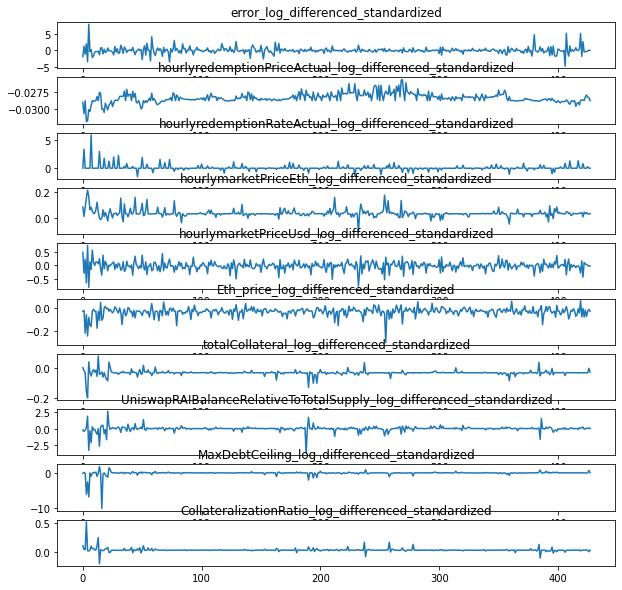

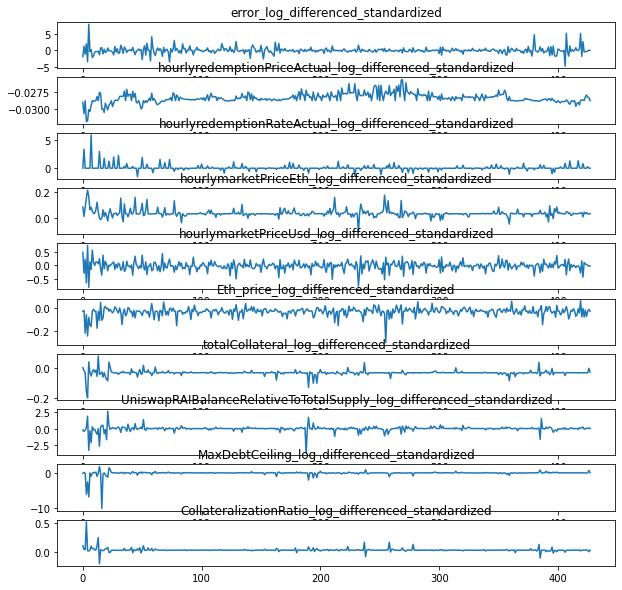

In [33]:
results.plot()

## Granger causality

Granger causality is a hypothesis test for determining whether one time series is useful in forecasting another. We can say that a variable X, or variables, evolves over time Granger-causes another evolving variable Y if predictions of the value of Y based on its own past values and on the past values of X are better than predictions of Y based only on Y's own past values. Granger Causality test IS NOT connected to VAR and will work with other Time series models.

In our analysis, we present the hypothesis that Eth is a driver of Rai market price. In statistical parlance, we have the following:

* $H_O: \textrm{Eth price does not Granger cause Rai market price}$
* $H_A: \textrm{Eth price does Granger cause Rai market price}$

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the eth price has any casual component for predicting the Rai market price. If the p-value (the probability of obtaining test results at least as extreme as the results actually observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that Eth price is a driver of Rai market price.

In [34]:
results.test_causality(['hourlymarketPriceEth_log_differenced_standardized', 
                        'hourlymarketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()


Test statistic,Critical value,p-value,df
7.785,2.374,0.000,"(4, 4050)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price.

In [35]:
results.test_causality('hourlymarketPriceEth_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
11.13,2.998,0.000,"(2, 4050)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Eth.

In [36]:
results.test_causality('hourlymarketPriceUsd_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
4.240,2.998,0.014,"(2, 4050)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth_price_log_differenced_standardized Eth price does have a causal influence on Rai price in Usd.

As we have many signals with the expanded V2 analysis, we will loop through all the signals, perform the Granger Causality test, and save the results for analysis.

## TODO:  Green for reject and red not correlated heatmap 

#https://seaborn.pydata.org/examples/spreadsheet_heatmap.html

In [37]:
# all combinations of signals
from itertools import combinations
combos = []
for combo in combinations(P.columns, 2):
    combos.append(combo)
    
alpha = 0.05
result_dfs = []
for i,j in combos:
        results_summary = results.test_causality(i,j, 
                                                 kind='f',signif=alpha).summary()


        df = pd.read_html(results_summary.as_html(),header=0, index_col=0)[0]
        df['alpha'] = alpha
        df['caused'] = i
        df['causing'] = j
        result_dfs.append(df)
        
Grangers_df = pd.concat(result_dfs)
Grangers_df.reset_index(inplace=True)
Grangers_df['result'] = Grangers_df['p-value'].apply(lambda x: 'reject H0' if x < alpha else 'fail to reject H0' )
Grangers_df


,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,2.20700,2.998,0.110,"(2, 4050)",0.05,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_st...,fail to reject H0
1,0.74690,2.998,0.474,"(2, 4050)",0.05,error_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_sta...,fail to reject H0
2,1.18800,2.998,0.305,"(2, 4050)",0.05,error_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,fail to reject H0
3,0.46040,2.998,0.631,"(2, 4050)",0.05,error_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,fail to reject H0
4,2.31800,2.998,0.099,"(2, 4050)",0.05,error_log_differenced_standardized,Eth_price_log_differenced_standardized,fail to reject H0
5,6.47400,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,totalCollateral_log_differenced_standardized,reject H0
6,0.97900,2.998,0.376,"(2, 4050)",0.05,error_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_dif...,fail to reject H0
7,0.70180,2.998,0.496,"(2, 4050)",0.05,error_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,fail to reject H0
8,6.50700,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,CollateralizationRatio_log_differenced_standar...,reject H0
9,2.97400,2.998,0.051,"(2, 4050)",0.05,hourlyredemptionPriceActual_log_differenced_st...,hourlyredemptionRateActual_log_differenced_sta...,fail to reject H0


In [38]:
#Grangers_df.reset_index(inplace=True)
Grangers_df

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,2.20700,2.998,0.110,"(2, 4050)",0.05,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_st...,fail to reject H0
1,0.74690,2.998,0.474,"(2, 4050)",0.05,error_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_sta...,fail to reject H0
2,1.18800,2.998,0.305,"(2, 4050)",0.05,error_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,fail to reject H0
3,0.46040,2.998,0.631,"(2, 4050)",0.05,error_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,fail to reject H0
4,2.31800,2.998,0.099,"(2, 4050)",0.05,error_log_differenced_standardized,Eth_price_log_differenced_standardized,fail to reject H0
5,6.47400,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,totalCollateral_log_differenced_standardized,reject H0
6,0.97900,2.998,0.376,"(2, 4050)",0.05,error_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_dif...,fail to reject H0
7,0.70180,2.998,0.496,"(2, 4050)",0.05,error_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,fail to reject H0
8,6.50700,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,CollateralizationRatio_log_differenced_standar...,reject H0
9,2.97400,2.998,0.051,"(2, 4050)",0.05,hourlyredemptionPriceActual_log_differenced_st...,hourlyredemptionRateActual_log_differenced_sta...,fail to reject H0


Text(0.5, 0.98, 'Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')

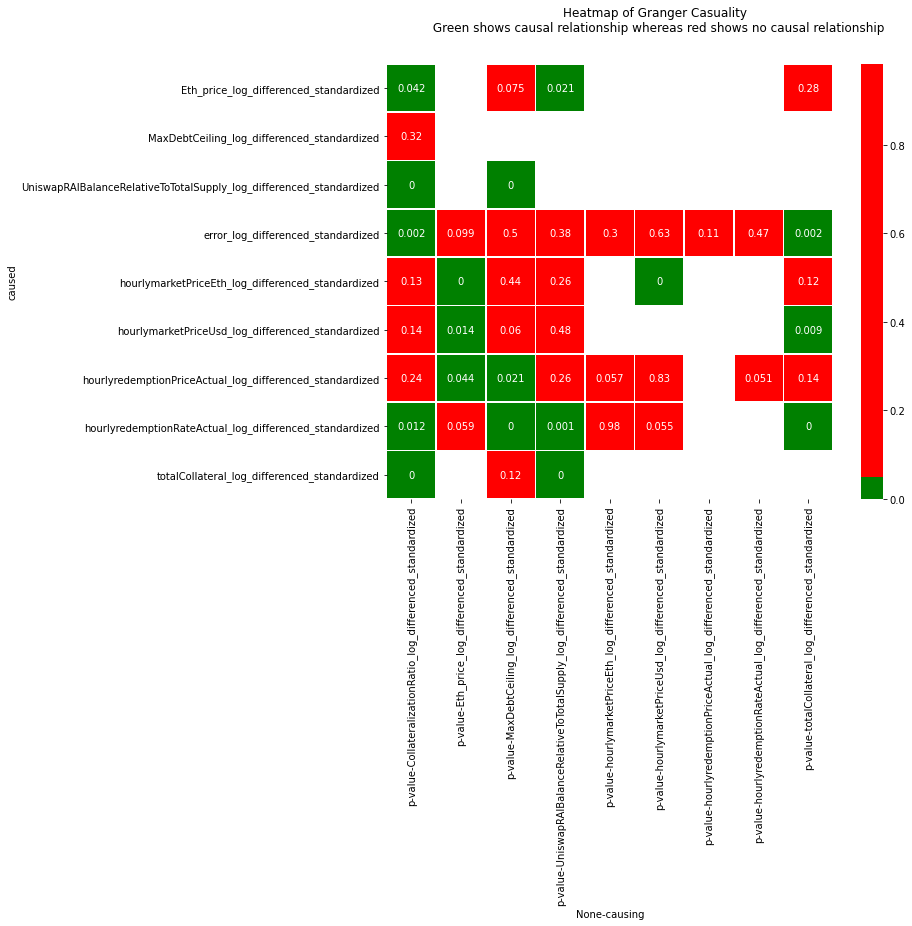

In [39]:

heatdf = Grangers_df.pivot(index='caused', columns=['causing'],values=['p-value'])

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatdf, annot=True, linewidths=.5, ax=ax,cmap=['green','red'],center=0.05)
plt.suptitle('Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')


In [40]:
Grangers_df.query("result == 'reject H0'")

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
5,6.474,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,totalCollateral_log_differenced_standardized,reject H0
8,6.507,2.998,0.002,"(2, 4050)",0.05,error_log_differenced_standardized,CollateralizationRatio_log_differenced_standar...,reject H0
12,3.117,2.998,0.044,"(2, 4050)",0.05,hourlyredemptionPriceActual_log_differenced_st...,Eth_price_log_differenced_standardized,reject H0
15,3.855,2.998,0.021,"(2, 4050)",0.05,hourlyredemptionPriceActual_log_differenced_st...,MaxDebtCeiling_log_differenced_standardized,reject H0
20,21.470,2.998,0.000,"(2, 4050)",0.05,hourlyredemptionRateActual_log_differenced_sta...,totalCollateral_log_differenced_standardized,reject H0
21,6.586,2.998,0.001,"(2, 4050)",0.05,hourlyredemptionRateActual_log_differenced_sta...,UniswapRAIBalanceRelativeToTotalSupply_log_dif...,reject H0
22,37.460,2.998,0.000,"(2, 4050)",0.05,hourlyredemptionRateActual_log_differenced_sta...,MaxDebtCeiling_log_differenced_standardized,reject H0
23,4.436,2.998,0.012,"(2, 4050)",0.05,hourlyredemptionRateActual_log_differenced_sta...,CollateralizationRatio_log_differenced_standar...,reject H0
24,9.536,2.998,0.000,"(2, 4050)",0.05,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,reject H0
25,11.130,2.998,0.000,"(2, 4050)",0.05,hourlymarketPriceEth_log_differenced_standardized,Eth_price_log_differenced_standardized,reject H0


## Impulse Response (Shock) Analysis

Impulse response is used in econometrics and macroeconomic modeling to study how the system reacts to unit exogenous shocks. In signal processing, an impulse response is the reaction of a dynamic system in response to some external change. The Impulse response below is the estimated responses of a variable to a unit impulse.

## Add units/scale - Eth_price_log_differenced_standardized same with impulse.
## Add look-up table for comparing number to "normal" numbers. Put a separate y axis and convert it human readable. 

In [55]:
inversed = scalers['Eth_price_log_differenced'].inverse_transform(P['Eth_price_log_differenced_standardized'])
Eth_price = np.exp(inversed).cumsum()
Eth_price

array([  1.        ,   2.00124993,   2.96055445,   3.95410996,
         4.9080337 ,   5.896565  ,   6.87035023,   7.84182217,
         8.84182217,   9.84584109,  10.84584109,  11.84584109,
        12.81411501,  13.81411501,  14.79703748,  15.81392285,
        16.79696287,  17.78389218,  18.7902579 ,  19.79965711,
        20.80420008,  21.80990672,  22.80990672,  23.81376588,
        24.81376588,  25.81066627,  26.81066627,  27.81896191,
        28.82415132,  29.82415132,  30.82078624,  31.82716953,
        32.82495173,  33.79978818,  34.79640741,  35.80067781,
        36.79197055,  37.7867854 ,  38.79372179,  39.79936513,
        40.79797773,  41.79797773,  42.78749408,  43.78922808,
        44.77659818,  45.77659818,  46.77718631,  47.77718631,
        48.77707163,  49.77346761,  50.76528797,  51.76528797,
        52.76736072,  53.76736072,  54.76369651,  55.76369651,
        56.75238414,  57.75238414,  58.76716159,  59.76716159,
        60.7511581 ,  61.7511581 ,  62.7511581 ,  63.75

In [53]:
graphData['Eth_price']

0       1803.656430
1       1803.656430
2       1763.974936
3       1763.974936
4       1763.974936
           ...     
1233    2076.760000
1234    2076.760000
1235    2067.997472
1236    2070.660000
1237    2096.829492
Name: Eth_price, Length: 1238, dtype: float64

In [42]:
# 50 periods
irf = results.irf(50)

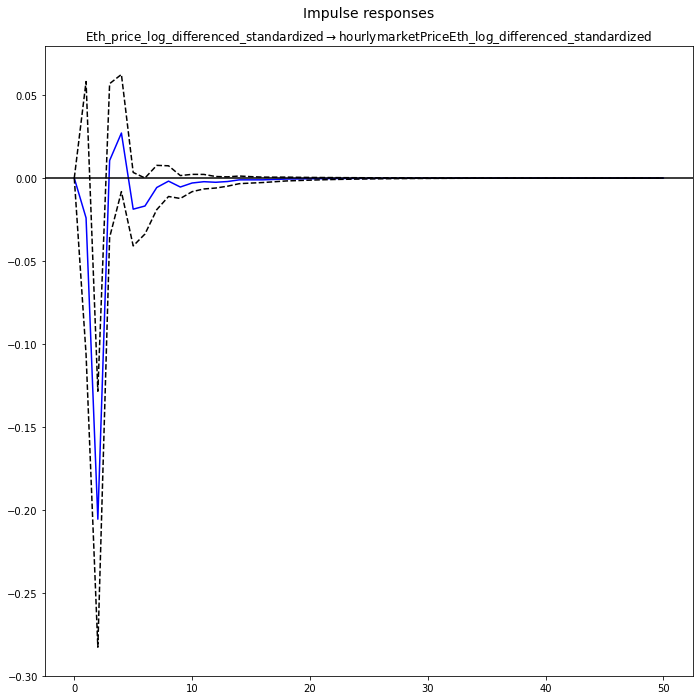

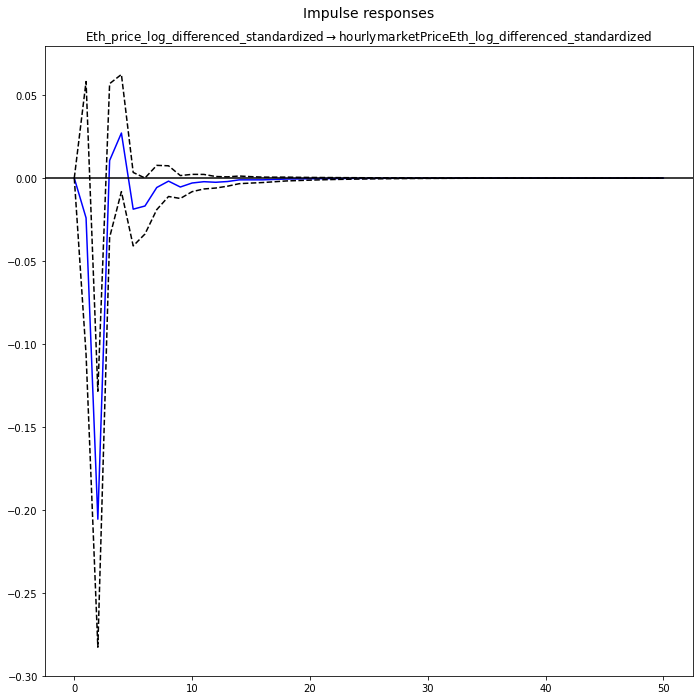

In [43]:
irf.plot(impulse='Eth_price_log_differenced_standardized', #variable providing the unit impulse
         response='hourlymarketPriceEth_log_differenced_standardized', # variable affected by the impulse
         plot_stderr = True, #Plot standard impulse response error bands
        repl=1000) #Number of replications for Monte Carlo and Sims-Zha standard errors

Standard errors are plotted by default at the 95% significance level.

# TODO: State that this shows us that after a shock value reverts back to mean very fast. Include percentages in write-up

## Correlation Analysis

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
error_log_differenced_standardized,1.000000,-0.017997,-0.064108,0.013559,-0.780073,0.147252,0.099872,-0.179448,-0.219341,0.060635
hourlyredemptionPriceActual_log_differenced_standardized,-0.017997,1.000000,-0.169083,-0.150673,0.029894,0.149618,0.137044,-0.048035,0.254861,-0.140565
hourlyredemptionRateActual_log_differenced_standardized,-0.064108,-0.169083,1.000000,0.072352,0.007707,-0.117107,0.037960,-0.260606,0.052400,-0.071193
hourlymarketPriceEth_log_differenced_standardized,0.013559,-0.150673,0.072352,1.000000,0.085256,-0.257451,-0.134557,-0.260318,-0.204680,0.181594
hourlymarketPriceUsd_log_differenced_standardized,-0.780073,0.029894,0.007707,0.085256,1.000000,-0.159450,-0.060143,0.151844,0.227866,-0.138781
Eth_price_log_differenced_standardized,0.147252,0.149618,-0.117107,-0.257451,-0.159450,1.000000,0.134386,0.079146,0.167048,-0.036449
totalCollateral_log_differenced_standardized,0.099872,0.137044,0.037960,-0.134557,-0.060143,0.134386,1.000000,-0.187420,0.299737,-0.073776
UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,-0.179448,-0.048035,-0.260606,-0.260318,0.151844,0.079146,-0.187420,1.000000,0.034020,0.137925
MaxDebtCeiling_log_differenced_standardized,-0.219341,0.254861,0.052400,-0.204680,0.227866,0.167048,0.299737,0.034020,1.000000,-0.412876
CollateralizationRatio_log_differenced_standardized,0.060635,-0.140565,-0.071193,0.181594,-0.138781,-0.036449,-0.073776,0.137925,-0.412876,1.000000


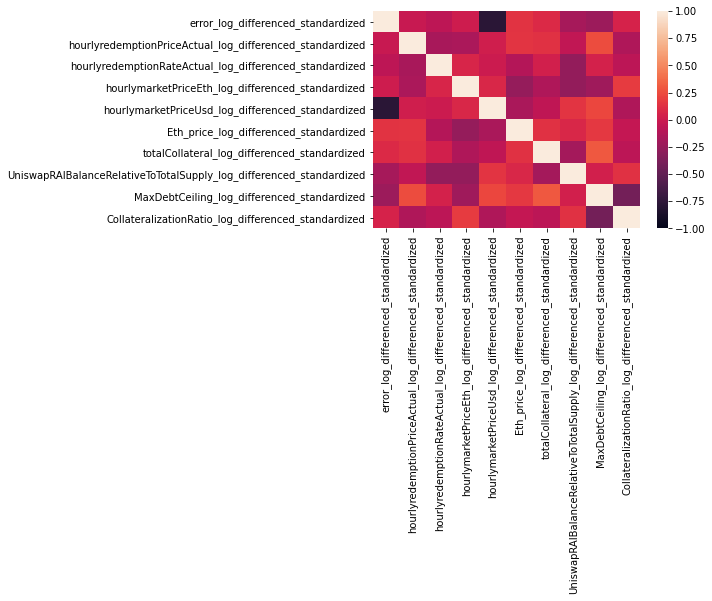

In [44]:
corr = P.corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

### Validation of the relationship between the redemption rate to redemption price and error to redemption rate

# TODO: 
* Should be able to compare observed data of redemption price and redemption rate (rate at which the price is changing) (line up redemption rate to changes in the redemption price)
* Make a dataframe of index, timestamp, time differential, redemption rate, redemption price. 
* Directly demonstrate that the redemption price is being determined by the redemption rate as coded in the Rai system. 
* Verification test. The system did what you coded it to do

In [45]:
validation = graphData[['timestamp','timestampDiff','hourlyredemptionRateActual','hourlyredemptionPriceActual','hourlymarketPriceUsd','error']]

In [46]:
validation.head()

,timestamp,timestampDiff,hourlyredemptionRateActual,hourlyredemptionPriceActual,hourlymarketPriceUsd,error
0,1613338681,NaN,1.0,3.14,4.670500,-1.530500
1,1613384616,45935.0,1.0,3.14,4.377049,-1.237049
2,1613387890,3274.0,1.0,3.14,4.406833,-1.266833
3,1613392101,4211.0,1.0,3.14,4.419266,-1.279266
4,1613394096,1995.0,1.0,3.14,3.194330,-0.054330


In [47]:
validation.tail()

,timestamp,timestampDiff,hourlyredemptionRateActual,hourlyredemptionPriceActual,hourlymarketPriceUsd,error
1233,1617957529,4203.0,0.999979,3.028091,3.077650,-0.049559
1234,1617959058,1529.0,0.999979,3.028091,3.077650,-0.049559
1235,1617962942,3884.0,0.999979,3.028058,3.066421,-0.038364
1236,1617968280,5338.0,0.999979,3.027930,3.090094,-0.062165
1237,1617973066,4786.0,0.999978,3.027816,3.075314,-0.047499


In [48]:
# OLD solidity
import math
validation.hourlyredemptionPriceActual.values[-2] * math.exp(validation.hourlyredemptionRateActual.values[-2] * validation.timestampDiff.values[-2]/3600)

13.338114834756906

In [49]:
target_price = (
            round(validation.hourlyredemptionPriceActual.values[-2],2) * (1 + round(validation.hourlyredemptionRateActual.values[-2],2)) ** round(validation.timestampDiff.values[-2]/3600,2)
        )
target_price

8.452146618083455

In [50]:
validation.hourlyredemptionPriceActual.values[-1]

3.027815530420219

## Confusion on how controller was acting. Keep this out of scope for Friday. Linear vs componding


### Find a way to force them to match.

## Talk to Markus about this?

controllers.py
```
def update_target_price(params, substep, state_history, state, policy_input):
    """
    Update the controller target_price state ("redemption price") according to the controller target_rate state ("redemption rate")

    Notes:
    * exp(bt) = (1+b)**t for low values of b; but to avoid compounding errors
    * we should probably stick to the same implementation as the solidity version
    * target_price =  state['target_price'] * FXnum(state['target_rate'] * state['timedelta']).exp()
    * target_price =  state['target_price'] * math.exp(state['target_rate'] * state['timedelta'])
    """

    target_price = state["target_price"]
    try:
        target_price = (
            state["target_price"] * (1 + state["target_rate"]) ** state["timedelta"]
        )
    except OverflowError as e:
        raise failure.ControllerTargetOverflowException((e, target_price))

    if target_price < 0:
        target_price = 0

    return "target_price", target_price
```

## Conclusion
# UPDATE - Why we need dynamical systems model

Based on our VAR analysis without interpolation, validating our hypothesis, Eth price does have an influence on the Rai price. Because the timesteps differences are approximately normally distruted, we can assume that this analysis is correct. We can explore nonlinear interpolation or more intelligent resampling to make both results line up to improve our confidence of of the analysis.


## Next Steps
* Continued research on handling uneven time sampling